### Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from tqdm import tqdm
!pip install minisom
from minisom import MiniSom
 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### functions

In [2]:
def plot_tsne(X, y, target_names,title):
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(X)
    target_ids = range(len(target_names))

    plt.figure(figsize=(6, 5))
    colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
    
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
import warnings 
warnings.filterwarnings("ignore")

------------------------------------------------------------------------------------------------------------------

In [4]:
from sklearn.neighbors import KNeighborsClassifier

def build_KNN(X_train,y_train,X_test,y_test,k):
    "this function train the KNN model on the train data and return the accuracy on the test data "
    KNN_clf = KNeighborsClassifier(n_neighbors = k)
    
    #fit(X_train, y_train) : Fit the model according to the given training data.
    KNN_clf.fit(X_train, y_train)
    
    #score(X_test, y_test) : Return the mean accuracy on the given test data and labels.
    return KNN_clf.score(X_test,y_test)*100

In [5]:
from sklearn.linear_model import LogisticRegression 

def build_LR(X_train,y_train,X_test,y_test):
    "this function train the LR model on the train data and return the accuracy on the test data "
    LR_clf = LogisticRegression(random_state=0)
    
    #fit(X_train, y_train) : Fit the model according to the given training data.
    LR_clf.fit(X_train, y_train)
    
    #score(X_test, y_test) : Return the mean accuracy on the given test data and labels.
    return LR_clf.score(X_test,y_test)*100

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def build_kmeans(X, num_clusters):
    "this function fits Kmeans model on the data and return the moedl it self "
    model = KMeans(n_clusters=num_clusters, init='k-means++', random_state=0)
    # there is no need for X_test in the unsupervised learning 
    model.fit(X)
    return model

In [7]:
def plot_kmeans_siloutte_score(X, max_clusters):
    """this function Plots the silhouette score vs the number of clusters"""
    
    silut = []
    for i in range(2, max_clusters+1):
        # build the model with i clusters 
        k_m = build_kmeans(X, i)

        # we started with 2 clusters because selloute must have at least two clusters not only one cluster
        
        #silhouette_score : return Mean Silhouette Coefficient for all samples.
        silut.append(silhouette_score(X, k_m.labels_))

    fig = plt.figure(figsize=(15, 5))
    fig.suptitle('silhouette score for K-means model',fontsize=16)


    sub1 = plt.subplot(1, 2, 1)
    sub1.plot(range(2, max_clusters+1), silut)
    sub1.set_xlabel('Number of clusters',fontsize=14)
    sub1.set_ylabel('silhouette score',fontsize=14)
    
    plt.show()

In [8]:
def plot_kmeans_evaluation_measures(X, max_clusters):
    """ this function Plots both (the silhouette score vs the number of clusters) and (the WCSS  vs the number of clusters) ,
    so it can be used to determine the best number of clusters regarding to the elbow in WCSS curve , 
    and the heighest point in the curve of siloutte score 
    """
    wcss = []
    silut = []
    for i in range(1, max_clusters+1):
        # build the model with i clusters 
        k_m = build_kmeans(X, i)
        
        #inertia : returns Sum of squared distances of samples to their closest cluster center 
        wcss.append(k_m.inertia_)
        
        # because selloute must have at least two clusters not only one cluster
        if i>1:
            #silhouette_score : return Mean Silhouette Coefficient for all samples.
            silut.append(silhouette_score(X, k_m.labels_))

    fig = plt.figure(figsize=(15, 5))
    fig.suptitle('Elbow Method and seloutte score for K-means model',fontsize=16)

    sub1 = plt.subplot(1, 2, 1)
    sub1.plot(range(1, max_clusters+1), wcss)
    sub1.set_xlabel('Number of clusters',fontsize=14)
    sub1.set_ylabel('WCSS : within cluster sum of squared error',fontsize=14)

    sub2 = plt.subplot(1, 2, 2)
    sub2.plot(range(2, max_clusters+1), silut)
    sub2.set_xlabel('Number of clusters',fontsize=14)
    sub2.set_ylabel('silhouette score',fontsize=14)
    
    plt.show()

----------------------------------------------------------------------------------------------------------------------

# 1. Use scikit-learn to implement Logistic Regression ( LR ) and K-Nearest Neighbor ( KNN ) classifiers on the provided Diabetic dataset.

### Load the dataset 

In [9]:
dataset =pd.read_csv('Assignment3_dataset.csv')
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.411765,0.623116,0.573770,0.333333,0.254137,0.380030,0.035440,0.266667,0
1,0.294118,0.542714,0.590164,0.434343,0.088652,0.538003,0.078992,0.200000,0
2,0.058824,0.437186,0.491803,0.373737,0.088652,0.554396,0.184031,0.016667,0
3,0.058824,0.723618,0.672131,0.464646,0.212766,0.687034,0.109735,0.416667,1
4,0.058824,0.557789,0.508197,0.131313,0.215130,0.357675,0.025619,0.033333,0


In [10]:
X = dataset.iloc[:, :-1]   
y = dataset.iloc[:, -1] 

### make sure to use the first 576 rows (75%) for training and the remaining 192 rows (25%) for testing. 

In [11]:
X_train, X_test, y_train, y_test = X[0:576], X[576:], y[0:576], y[576:]
print(f"the shape of the training data :{X_train.shape}")
print(f"the shape of the testing  data :{X_test.shape}")

the shape of the training data :(576, 8)
the shape of the testing  data :(192, 8)


-----------------------------------------------------------------------------------------------------------------

### find the best k for KNN algorithm 

In [12]:
k_values = [1,2,3,4,5,6,7,8,9,10]
K_scores = []
for i in k_values:
    s = build_KNN(X_train,y_train,X_test,y_test,i)
    K_scores.append(s)

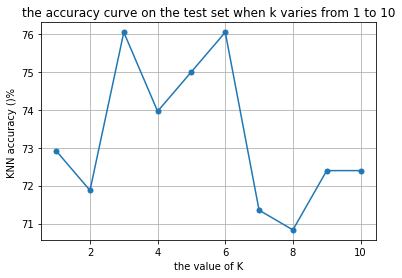

In [13]:
import matplotlib.pyplot as plt

plt.plot(k_values, K_scores,marker='o', markersize=5, label='validation Accuracy')
plt.xlabel('the value of K')
plt.ylabel('KNN accuracy ()% ')
plt.title("the accuracy curve on the test set when k varies from 1 to 10")
plt.grid()
plt.show()

In [14]:
# regarding to the curve the best k is : 
best_k_KNN = 3 

### (a) Provide the accuracy of LR and K-NN classifier as baseline performances. 

In [15]:
LR_accur_baseLine  = build_LR(X_train,y_train,X_test,y_test)
KNN_accur_baseLine = build_KNN(X_train,y_train,X_test,y_test,best_k_KNN)
print(f"the accuracy of LR  algorithm : ({round(LR_accur_baseLine,4)})%")
print(f"the accuracy of KNN algorithm : ({round(KNN_accur_baseLine,4)})%")


the accuracy of LR  algorithm : (77.0833)%
the accuracy of KNN algorithm : (76.0417)%


through this assignment we will face many number of accuracies and different training sets with two classifiers (LR and KNN )So, we have built 6 lists to keep track all of these information 

In [16]:
KNN_acc_summary   = [] 
KNN_title_summary = []
KNN_data_summary  = []

LR_acc_summary   = [] 
LR_title_summary = []
LR_data_summary  = []

In [17]:
KNN_acc_summary.append(KNN_accur_baseLine) 
KNN_title_summary.append("BaseLine") 
KNN_data_summary.append(X) 


LR_acc_summary.append(LR_accur_baseLine) 
LR_title_summary.append("BaseLine") 
LR_data_summary.append(X) 

### (b) Provide 2D TSNE plots, one for the training set and one for the test set.

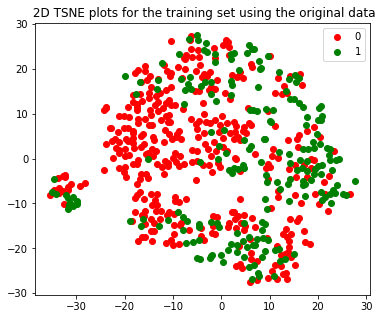

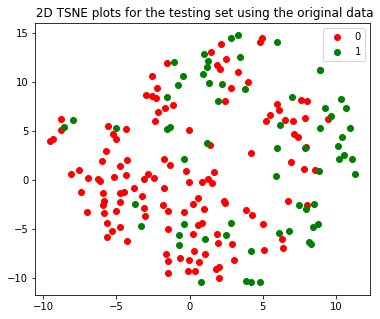

In [18]:
target_names=[0,1]
plot_tsne(X_train, y_train, target_names," 2D TSNE plots for the training set using the original data")
plot_tsne(X_test, y_test, target_names," 2D TSNE plots for the testing set using the original data")

-----------------------------------------------------------------------------------------------------------------

# 2. Choose the best number of cluster for k-means clustering algorithm

## (a) Plot the silhouette score vs the number of clusters. 

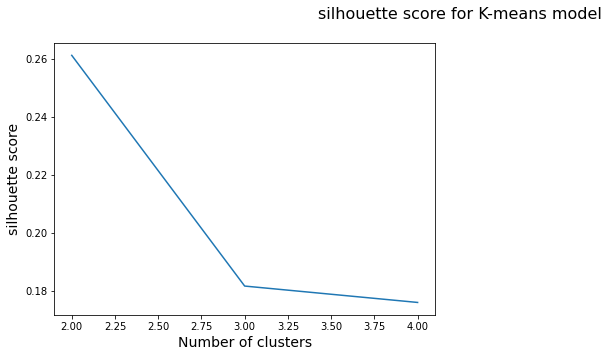

In [19]:
# we choosed the range of values for clusters to be from 2 to 4 
plot_kmeans_siloutte_score(X, 4)

## (b) Determine the optimal number of clusters for k-Means

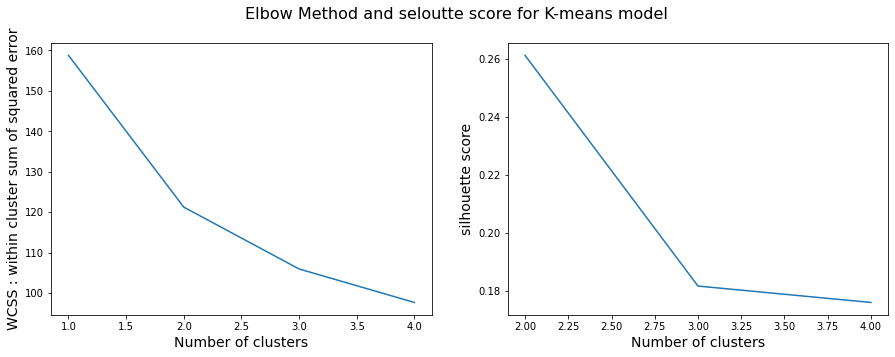

In [20]:
plot_kmeans_evaluation_measures(X, 4)

we choosed the clusters number with the heighest silloutte score (to minimize the distances between the data points in the same clusters and maximize the distances bewteen data points in different clusters )

to make sure we ploted the elbow to keep track of the sum of squared error within clusters with different number of K , we was hesitated between k = 2 and k = 3 , so we looked to the siloutte score so we choosed k = 2 , and logically it make sence because we have two classes in our dataset 

## (c) Plot the clustered data with optimum number of clusters. 

In [21]:
kmeans_model = KMeans(n_clusters=2, init='k-means++', random_state=0)

label = kmeans_model.fit_predict(X)

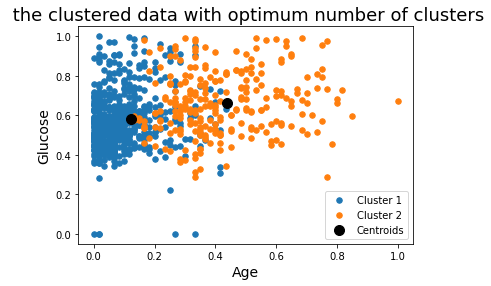

In [22]:
import matplotlib.pyplot as plt

# Visualising the clusters
plt.scatter(X[label== 0]['Age'], X[label == 0]['Glucose'], s = 30, label = 'Cluster 1')
plt.scatter(X[label == 1]['Age'], X[label== 1]['Glucose'], s = 30, label = 'Cluster 2')
 
plt.scatter(kmeans_model.cluster_centers_[:,0], kmeans_model.cluster_centers_[:,1], s = 100, c = 'black', label = 'Centroids')
plt.title(' the clustered data with optimum number of clusters',fontsize=18)
plt.xlabel('Age',fontsize=14)
plt.ylabel('Glucose',fontsize=14)
plt.legend()
plt.show()

## Visualize all the original dimensions

each subplot displays a feature against another ,  some pairs of features can more easily separate different species

In [23]:
import plotly.express as px

X_copy=X.copy() 
X_copy['target']=label
 

fig = px.scatter_matrix(
    X_copy,
    dimensions=X_copy.columns[:-1],
  color="target"
)
fig.update_traces(diagonal_visible=False)

fig.show()

to plot the data we must use only two features  , so we choosed "Age" and "Glucose"

----------------------------------------------------------------------------------------------------------------

## 3. Apply the following Dimensionality Reduction (DR) methods: 
PCA(n components=n, random state=0)

(a) Find the best value of n components, based on test accuracies, for both classifiers (LR and K-NN).

In [24]:
def perform_PCA(X,y,c):
    """
    this function take the data (X and y) and number of components  to :
    1. applay PCA -dimentionality reduction technique-
    2. split the data to training and testing then building our two classifiers 
    3. get the accuracy of the two classifiers with specific number of component
    finnaly, return the accuracy of the two classifiers ,and the improved data with PCA.  
    """
    X2 = X
    y2 = y
    pca = PCA(n_components=c,random_state=0)
    X_pca = pca.fit_transform(X2)
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = X_pca[0:576], X_pca[576:], y2[0:576], y2[576:] 

    LR_accur  = build_LR(X_train_pca,y_train_pca,X_test_pca,y_test_pca)
    KNN_accur = build_KNN(X_train_pca,y_train_pca,X_test_pca,y_test_pca,3)
    
    print(f"the accuracy of LR  algorithm  after applaying PCA with {c} components:({LR_accur})%")
    print("")
    
    print(f"the accuracy of KNN algorithm  after applaying PCA with {c} components:({KNN_accur})%")
    print("==========================================================================================")
    
    return LR_accur , KNN_accur , X_pca

In [25]:
n_components = [1,2,3,4,5,6,7,8]
LR_accuracies = []
KNN_accuracies = []
pca_data_lst = []
for c in n_components:
    LR_accur,KNN_accur,data_pca= perform_PCA(X,y,c)
    LR_accuracies.append(LR_accur)
    KNN_accuracies.append(KNN_accur)
    pca_data_lst.append(data_pca)

the accuracy of LR  algorithm  after applaying PCA with 1 components:(69.79166666666666)%

the accuracy of KNN algorithm  after applaying PCA with 1 components:(65.625)%
the accuracy of LR  algorithm  after applaying PCA with 2 components:(69.79166666666666)%

the accuracy of KNN algorithm  after applaying PCA with 2 components:(64.58333333333334)%
the accuracy of LR  algorithm  after applaying PCA with 3 components:(76.5625)%

the accuracy of KNN algorithm  after applaying PCA with 3 components:(71.35416666666666)%
the accuracy of LR  algorithm  after applaying PCA with 4 components:(76.04166666666666)%

the accuracy of KNN algorithm  after applaying PCA with 4 components:(76.04166666666666)%
the accuracy of LR  algorithm  after applaying PCA with 5 components:(76.5625)%

the accuracy of KNN algorithm  after applaying PCA with 5 components:(73.4375)%
the accuracy of LR  algorithm  after applaying PCA with 6 components:(76.5625)%

the accuracy of KNN algorithm  after applaying PCA with

In [26]:
def find_best_n_component(acc_lst,component_lst,model_name):
  m = np.max(acc_lst)
  i = acc_lst.index(m)
  n = component_lst[i]
  print(f"the best value of n_components, based on test accuracies,for {model_name} classifier ")
  print(f"best accuracy is :( {round(m,4)} )%")
  print(f"best number of component is : {n}")
  print("==========================================================")

In [27]:
find_best_n_component(KNN_accuracies,n_components,"KNN")
find_best_n_component(LR_accuracies,n_components,"LR")

the best value of n_components, based on test accuracies,for KNN classifier 
best accuracy is :( 76.0417 )%
best number of component is : 4
the best value of n_components, based on test accuracies,for LR classifier 
best accuracy is :( 78.6458 )%
best number of component is : 7


(b) Plot the Number of Components-Accuracy graph with baseline performances for
each classifier 
The Graph should be plotted based on the test
accuracy. (Use bar chart)

In [28]:
def plot_curve_bar_chart_for_PCA(n_components,accuracies,model_name,baseline_acc):
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(f"{model_name} model Accuracies after applay PCA Method to reduce feature dimension",fontsize=16)

    sub1  = plt.subplot(1, 2, 1)
    sub1.plot(n_components,accuracies,label = "PCA")
    base_line_accs = [baseline_acc for n in n_components]
    sub1.plot(n_components,base_line_accs,label = "BaseLine")
    sub1.set_xlabel("Number of Components", fontsize=16)
    sub1.set_ylabel(f"{model_name}_Accuracy (%)", fontsize=16)
    sub1.legend(loc="lower right")

    sub2 = plt.subplot(1, 2, 2)

    n_components = [str(c) for c in n_components]
    n_components.append("BaseLine")
    accuracies.append(baseline_acc)
    sub2.bar(n_components,accuracies,color ='maroon',width = 0.4)
  

    sub2.set_xlabel("Number of Components", fontsize=16)
    sub2.set_ylabel(f"{model_name}_Accuracy (%)", fontsize=16)

    bar = sub2 

    plt.show()
    

In [29]:
def find_n_with_max_accuracy(n_components,accuracies,pca_data,model_name):
    max_index = accuracies.index(max(accuracies))
    n_comp = n_components[max_index]
    pca_acc = max(accuracies)
    print(f"Maximum accuracy for {model_name} model after PCA is  :{pca_acc} ")
    print(f"the best N component for PCA based on {model_name} is :", n_comp)
    return pca_acc , pca_data[max_index]

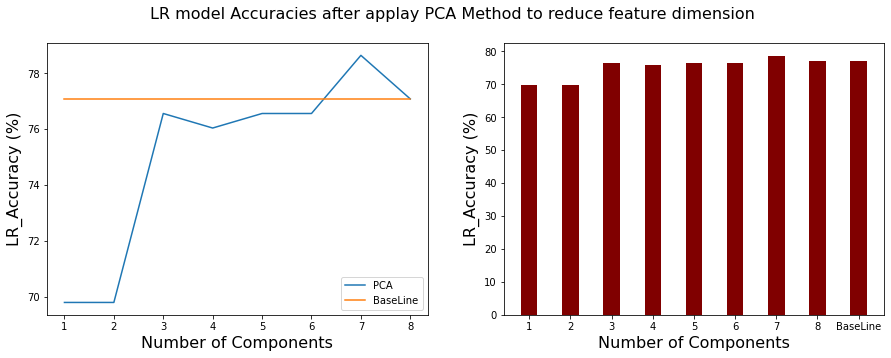

In [30]:
plot_curve_bar_chart_for_PCA(n_components,LR_accuracies,"LR",LR_acc_summary[0])


In [31]:
LR_PCA_acc ,LR_pca_best_data = find_n_with_max_accuracy(n_components,LR_accuracies,pca_data_lst,"LR")

Maximum accuracy for LR model after PCA is  :78.64583333333334 
the best N component for PCA based on LR is : 7


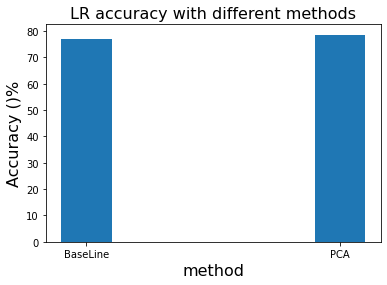

In [32]:
fig = plt.figure()

x_axis=["BaseLine","PCA"]
y_axis=[LR_accur_baseLine,LR_PCA_acc]
plt.bar(x_axis,y_axis,width=0.2)
plt.xlabel("method", fontsize=16)
plt.ylabel("Accuracy ()%", fontsize=16)
plt.title("LR accuracy with different methods",fontsize=16)
plt.show()

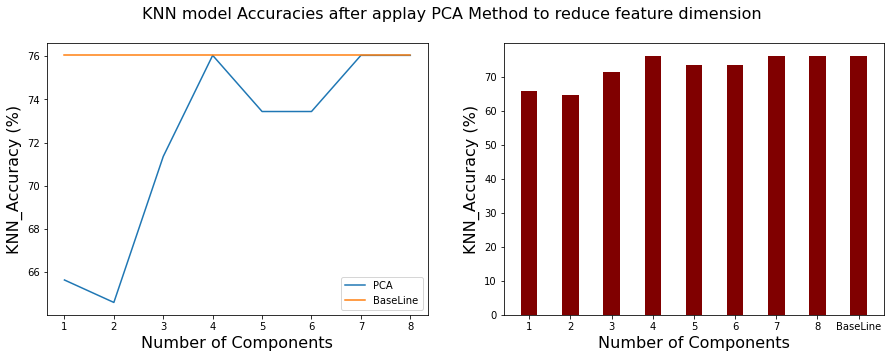

In [33]:
plot_curve_bar_chart_for_PCA(n_components,KNN_accuracies,"KNN",KNN_acc_summary[0])



In [34]:
KNN_PCA_acc ,KNN_pca_best_data =find_n_with_max_accuracy(n_components,KNN_accuracies,pca_data_lst,"KNN")

Maximum accuracy for KNN model after PCA is  :76.04166666666666 
the best N component for PCA based on KNN is : 4


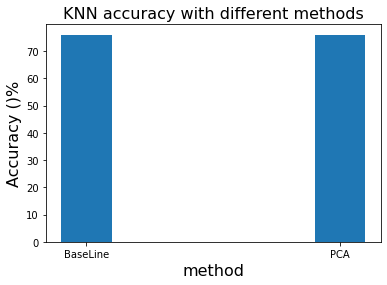

In [35]:
fig = plt.figure()

x_axis=["BaseLine","PCA"]
y_axis=[KNN_accur_baseLine,KNN_PCA_acc]
plt.bar(x_axis,y_axis,width=0.2)
plt.xlabel("method", fontsize=16)
plt.ylabel("Accuracy ()%", fontsize=16)
plt.title("KNN accuracy with different methods",fontsize=16)
plt.show()

In [36]:
KNN_acc_summary.append(KNN_PCA_acc) 
KNN_title_summary.append("with_PCA") 
KNN_data_summary.append(KNN_pca_best_data) 


LR_acc_summary.append(LR_PCA_acc) 
LR_title_summary.append("with_PCA") 
LR_data_summary.append(LR_pca_best_data) 


(c) Provide 2D TSNE plots, one for the training set and one for the test set. 

In [37]:
pca = PCA(n_components=7,random_state=0)
X_pca = pca.fit_transform(X)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = X_pca[0:576], X_pca[576:], y[0:576], y[576:] 


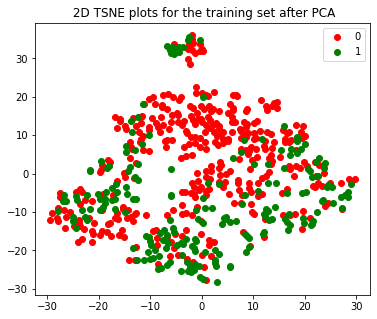

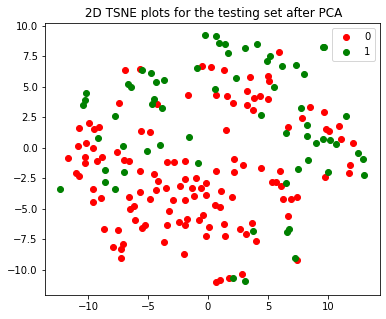

In [38]:
pca = PCA(n_components=7,random_state=0)
X_pca = pca.fit_transform(X)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = X_pca[0:576], X_pca[576:], y[0:576], y[576:] 

target_names=[0,1]
plot_tsne(X_train_pca, y_train_pca, target_names," 2D TSNE plots for the training set after PCA")
plot_tsne(X_test_pca, y_test_pca, target_names," 2D TSNE plots for the testing set after PCA")

--------------------------------------------------------------------------------------------------------------

## 4. Use the following Feature Selection methods (one for each method).
Find the best number of features based on both, the LR and K-NN classifiers’ test accuracies.

(a) Filter Methods (Information Gain, Variance Threshold etc.). Plot the number of
features versus accuracy graph with the improved baseline performance as shown
in Q3, using only the method that gives you the best test accuracy

In [39]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score

def select_feature(X_train, y_train, X_test, y_test, FSM, model):
    """
    input  :  X_train, y_train, X_test, y_test, FSM : feature selection method , model
    output : it apply feature selection method then train the model and return the accuracy of the model 
    """
    fs = FSM
    fs.fit(X_train, y_train)
    new_X_total = fs.transform(X)
    X_train_new = fs.transform(X_train)
    X_test_new = fs.transform(X_test) 
    model.fit(X_train_new, y_train)
    y_pred = model.predict(X_test_new)
    acc = accuracy_score(y_test, y_pred) * 100

    return acc , new_X_total

In [40]:
def select_plot(acc_dict,method_name,model_name):
    plt.plot(*zip(*sorted(acc_dict.items())))
    Title = f"Feature Selection with {method_name} method,based on {model_name} model "
    plt.title(Title, fontsize=16)
    plt.xlabel("Number of Features", fontsize=16)
    plt.ylabel(f"{model_name} Accuracy (%)", fontsize=16)
    plt.show()

    print(f"Maximum accuracy of {model_name} model         :", max(acc_dict.values()))
    print(f"Best number of features for {model_name} model :", max(acc_dict, key=acc_dict.get))

In [41]:
def select_get_accuracies(model,fsm_method,X_train, y_train, X_test, y_test,method_name,model_name):
    acc_dict_return = {}
    acc_dict = []
    f = []
    X_dict = []

    for nf in range(1,9):
        fsm =  SelectKBest(fsm_method, k=nf)
        acc , new_X_total = select_feature(X_train, y_train, X_test, y_test, fsm, model)
        acc_dict.append(acc)
        f.append(nf)
        X_dict.append(new_X_total)
        acc_dict_return[nf] = acc

    max_method_acc = max(acc_dict)
    max_index_filter = acc_dict.index(max_method_acc)

    
    print(f'with \"{method_name}\" filter method')
    
    print(acc_dict_return)
    print(f"Maximum accuracy of {model_name} model         :{max_method_acc} %")
    print(f"Best number of features for {model_name} model :{f[max_index_filter]}")

    print("===================================================================================")
    


    return max_method_acc , acc_dict_return , X_dict[max_index_filter]

In [42]:
KNN_clf = KNeighborsClassifier(n_neighbors = 3)

KNN_MutualInfo_acc,dct1,filter_data_1= select_get_accuracies(KNN_clf,mutual_info_classif,X_train, y_train, X_test, y_test,"Mutual information","KNN")
KNN_ANOVA_acc     ,dct2,filter_data_2= select_get_accuracies(KNN_clf,f_classif,X_train, y_train, X_test, y_test,"ANOVA F-value","KNN")
KNN_chi_square_acc,dct3,filter_data_3= select_get_accuracies(KNN_clf,chi2,X_train, y_train, X_test, y_test,"chi square","KNN")

with "Mutual information" filter method
{1: 62.5, 2: 70.3125, 3: 75.52083333333334, 4: 72.91666666666666, 5: 71.875, 6: 72.91666666666666, 7: 72.39583333333334, 8: 76.04166666666666}
Maximum accuracy of KNN model         :76.04166666666666 %
Best number of features for KNN model :8
with "ANOVA F-value" filter method
{1: 68.75, 2: 70.3125, 3: 75.52083333333334, 4: 77.60416666666666, 5: 72.91666666666666, 6: 71.875, 7: 72.39583333333334, 8: 76.04166666666666}
Maximum accuracy of KNN model         :77.60416666666666 %
Best number of features for KNN model :4
with "chi square" filter method
{1: 64.0625, 2: 70.83333333333334, 3: 74.47916666666666, 4: 75.0, 5: 77.08333333333334, 6: 71.875, 7: 72.39583333333334, 8: 76.04166666666666}
Maximum accuracy of KNN model         :77.08333333333334 %
Best number of features for KNN model :5


In [43]:
KNN_filter_methods_acc =[KNN_MutualInfo_acc,KNN_ANOVA_acc,KNN_chi_square_acc] 
KNN_filter_methods_data =[filter_data_1,filter_data_2,filter_data_3] 
KNN_filter_methods_names = ["Mutual information","ANOVA F-value","chi square"]


KNN_filter_methods_max_acc = max(KNN_filter_methods_acc)
KNN_filter_methods_max_acc_index = KNN_filter_methods_acc.index(KNN_filter_methods_max_acc)
KNN_filter_methods_max_acc_data  = KNN_filter_methods_data[KNN_filter_methods_max_acc_index]
print(f"kNN best accuracy with feature selection techniques (filter method) is : {KNN_filter_methods_max_acc}")
print(f"statistic method used is : {KNN_filter_methods_names[KNN_filter_methods_max_acc_index]}")

KNN_acc_summary.append(KNN_filter_methods_max_acc) 
KNN_title_summary.append("with_feature_selection") 
KNN_data_summary.append(KNN_filter_methods_max_acc_data) 

kNN best accuracy with feature selection techniques (filter method) is : 77.60416666666666
statistic method used is : ANOVA F-value


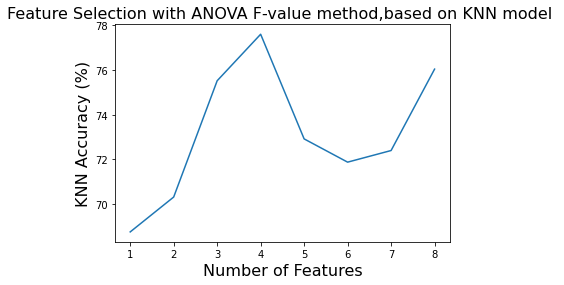

Maximum accuracy of KNN model         : 77.60416666666666
Best number of features for KNN model : 4


In [44]:
select_plot(dct2,"ANOVA F-value","KNN")
# select_plot(KNN_clf,mutual_info_classif,X_train, y_train, X_test, y_test,"Mutual information","KNN")
# select_plot(KNN_clf,chi2,X_train, y_train, X_test, y_test,"chi square","KNN")

In [45]:
LR_clf = LogisticRegression(random_state=0)

LR_MutualInfo_acc,dct4,filter_data_4= select_get_accuracies(LR_clf,mutual_info_classif,X_train, y_train, X_test, y_test,"Mutual information","LR")
LR_ANOVA_acc     ,dct5,filter_data_5 = select_get_accuracies(LR_clf,f_classif,X_train, y_train, X_test, y_test,"ANOVA F-value","LR")
LR_chi_square_acc ,dct6,filter_data_6= select_get_accuracies(LR_clf,chi2,X_train, y_train, X_test, y_test,"chi square","LR")

with "Mutual information" filter method
{1: 75.52083333333334, 2: 77.08333333333334, 3: 78.125, 4: 78.64583333333334, 5: 78.64583333333334, 6: 77.60416666666666, 7: 78.125, 8: 77.08333333333334}
Maximum accuracy of LR model         :78.64583333333334 %
Best number of features for LR model :4
with "ANOVA F-value" filter method
{1: 75.52083333333334, 2: 77.08333333333334, 3: 78.125, 4: 78.64583333333334, 5: 77.60416666666666, 6: 77.60416666666666, 7: 78.125, 8: 77.08333333333334}
Maximum accuracy of LR model         :78.64583333333334 %
Best number of features for LR model :4
with "chi square" filter method
{1: 65.10416666666666, 2: 77.60416666666666, 3: 78.125, 4: 77.60416666666666, 5: 78.125, 6: 77.60416666666666, 7: 78.125, 8: 77.08333333333334}
Maximum accuracy of LR model         :78.125 %
Best number of features for LR model :3


In [46]:
LR_filter_methods_acc =[LR_MutualInfo_acc,LR_ANOVA_acc,LR_chi_square_acc] 
LR_filter_methods_data =[filter_data_4,filter_data_5,filter_data_6] 
LR_filter_methods_names = ["Mutual information","ANOVA F-value","chi square"]

LR_filter_methods_max_acc = max(LR_filter_methods_acc)
LR_filter_methods_max_acc_index = LR_filter_methods_acc.index(LR_filter_methods_max_acc)
LR_filter_methods_max_acc_data  = LR_filter_methods_data[LR_filter_methods_max_acc_index]
print(f"LR best accuracy with feature selection techniques (filter method) is : {LR_filter_methods_max_acc}")
print(f"statistic method used is : {LR_filter_methods_names[LR_filter_methods_max_acc_index]}")

LR_acc_summary.append(LR_filter_methods_max_acc) 
LR_title_summary.append("with_feature_selection") 
LR_data_summary.append(LR_filter_methods_max_acc_data) 

LR best accuracy with feature selection techniques (filter method) is : 78.64583333333334
statistic method used is : Mutual information


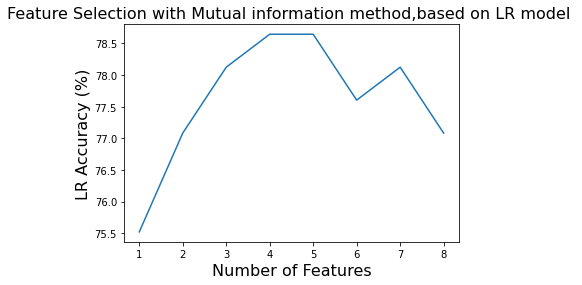

Maximum accuracy of LR model         : 78.64583333333334
Best number of features for LR model : 4


In [47]:
select_plot(dct4,"Mutual information","LR")
# select_plot(LR_clf,f_classif,X_train, y_train, X_test, y_test,"ANOVA F-value","LR")
# select_plot(LR_clf,chi2,X_train, y_train, X_test, y_test,"chi square","LR")

In [48]:
print("for LR model     :Accuracy")
print(f"BaseLine         :{LR_accur_baseLine}%")
print(f"PCA              :{LR_PCA_acc}%")
print(f"informtion_gaing :{LR_MutualInfo_acc}%")
print(f"ANOVA            :{LR_ANOVA_acc}%")
print(f"Chi-square       :{LR_chi_square_acc}%")

for LR model     :Accuracy
BaseLine         :77.08333333333334%
PCA              :78.64583333333334%
informtion_gaing :78.64583333333334%
ANOVA            :78.64583333333334%
Chi-square       :78.125%


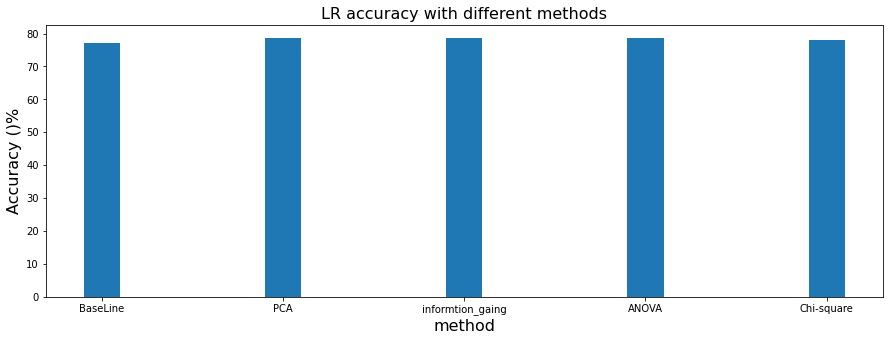

In [49]:
fig = plt.figure(figsize=(15, 5))

x_axis=["BaseLine","PCA","informtion_gaing","ANOVA","Chi-square"]
y_axis=[LR_accur_baseLine,LR_PCA_acc,LR_MutualInfo_acc,LR_ANOVA_acc,LR_chi_square_acc]
plt.bar(x_axis,y_axis,width=0.2)
plt.xlabel("method", fontsize=16)
plt.ylabel("Accuracy ()%", fontsize=16)
plt.title("LR accuracy with different methods",fontsize=16)
plt.show()

In [50]:
print("for KNN model    :Accuracy")
print(f"BaseLine         :{KNN_accur_baseLine}%")
print(f"PCA              :{KNN_PCA_acc}%")
print(f"informtion_gaing :{KNN_MutualInfo_acc}%")
print(f"ANOVA            :{KNN_ANOVA_acc}%")
print(f"Chi-square       :{KNN_chi_square_acc}%")

for KNN model    :Accuracy
BaseLine         :76.04166666666666%
PCA              :76.04166666666666%
informtion_gaing :76.04166666666666%
ANOVA            :77.60416666666666%
Chi-square       :77.08333333333334%


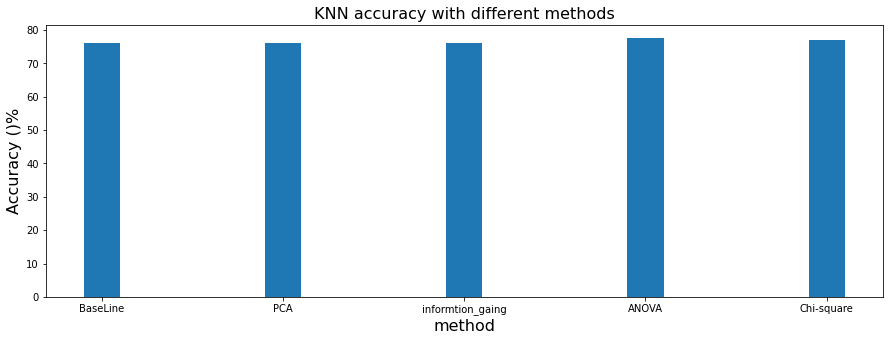

In [51]:
fig = plt.figure(figsize=(15, 5))

x_axis=["BaseLine","PCA","informtion_gaing","ANOVA","Chi-square"]
y_axis=[KNN_accur_baseLine,KNN_PCA_acc,KNN_MutualInfo_acc,KNN_ANOVA_acc,KNN_chi_square_acc]
plt.bar(x_axis,y_axis,width=0.2)
plt.xlabel("method", fontsize=16)
plt.ylabel("Accuracy ()%", fontsize=16)
plt.title("KNN accuracy with different methods",fontsize=16)
plt.show()

(b) Wrapper Methods (Forward or Backward Feature Elimination, Recursive Feature
Elimination etc.). Plot the number of features versus accuracy graph with the
improved baseline performance as shown in Q3, using only the method that gives
you the best test accuracy. 

In [52]:
from sklearn.feature_selection import SequentialFeatureSelector
dataColumns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']
features=[]
feature =[]
for i in range(1,X.shape[1]):
  sfs = SequentialFeatureSelector(KNN_clf, n_features_to_select=i,direction='forward')
  sfs.fit(X, y)
  res =sfs.get_support()
   
  for index,j in enumerate(res):
     
    if j ==True:
      feature.append(dataColumns[index])
      appendFeature = feature.copy()
       
  features.append(appendFeature)
   
  feature.clear()
features.append(dataColumns)

KNN_clf_model = KNeighborsClassifier(n_neighbors = 6)
KNN_features_forward = []
KNN_accs_forward = []
for features_name in features:
  KNN_clf_model.fit(X_train[features_name],y_train)
  KNN_y_pred = KNN_clf_model.predict(X_test[features_name])
  acc = accuracy_score(y_test, KNN_y_pred) * 100
  KNN_features_forward.append(features_name)
  KNN_accs_forward.append(acc)
KNN_accs_forward 

   
   


[73.95833333333334,
 71.35416666666666,
 73.4375,
 79.16666666666666,
 73.95833333333334,
 77.08333333333334,
 76.04166666666666,
 76.04166666666666]

In [53]:
 
dataColumns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']
features=[]
feature =[]
for i in range(1,X.shape[1]):
  sfs = SequentialFeatureSelector(LR_clf, n_features_to_select=i,direction='forward')
  sfs.fit(X, y)
  res =sfs.get_support()
   
  for index,j in enumerate(res):
     
    if j ==True:
      feature.append(dataColumns[index])
      appendFeature = feature.copy()
       
  features.append(appendFeature)
   
  feature.clear()
features.append(dataColumns)

LR_clf_model = LogisticRegression(random_state=0)
LR_features_forward = []
LR_accs_forward = []
for features_name in features:
  LR_clf_model.fit(X_train[features_name],y_train)
  LR_y_pred = LR_clf_model.predict(X_test[features_name])
  acc = accuracy_score(y_test, LR_y_pred) * 100
  LR_features_forward.append(features_name)
  LR_accs_forward.append(acc)
LR_accs_forward 



[75.52083333333334,
 77.08333333333334,
 77.60416666666666,
 77.60416666666666,
 77.60416666666666,
 77.60416666666666,
 78.125,
 77.08333333333334]

In [54]:
from sklearn.feature_selection import SequentialFeatureSelector
dataColumns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']
features=[]
feature =[]
for i in range(1,X.shape[1]):
  sfs = SequentialFeatureSelector(KNN_clf, n_features_to_select=i,direction='backward')
  sfs.fit(X, y)
  res =sfs.get_support()
   
  for index,j in enumerate(res):
     
    if j ==True:
      feature.append(dataColumns[index])
      appendFeature = feature.copy()
       
  features.append(appendFeature)
   
  feature.clear()
features.append(dataColumns)

KNN_clf_model = KNeighborsClassifier(n_neighbors = 6)
KNN_features_backward = []
KNN_accs_backward = []

for features_name in features:
  KNN_clf_model.fit(X_train[features_name],y_train)
  KNN_y_pred = KNN_clf_model.predict(X_test[features_name])
  acc = accuracy_score(y_test, KNN_y_pred) * 100
  KNN_features_backward.append(features_name)
  KNN_accs_backward.append(acc)
 
KNN_accs_backward
   
   


[73.95833333333334,
 71.35416666666666,
 72.39583333333334,
 71.875,
 75.52083333333334,
 77.60416666666666,
 76.04166666666666,
 76.04166666666666]

In [55]:
 
dataColumns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']
features=[]
feature =[]
for i in range(1,X.shape[1]):
  sfs = SequentialFeatureSelector(LR_clf, n_features_to_select=i,direction='backward')
  sfs.fit(X, y)
  res =sfs.get_support()
   
  for index,j in enumerate(res):
     
    if j ==True:
      feature.append(dataColumns[index])
      appendFeature = feature.copy()
       
  features.append(appendFeature)
   
  feature.clear()
features.append(dataColumns)

LR_clf_model = LogisticRegression(random_state=0)
LR_features_backward = []
LR_accs_backward = []
for features_name in features:
  LR_clf_model.fit(X_train[features_name],y_train)
  LR_y_pred = LR_clf_model.predict(X_test[features_name])
  acc = accuracy_score(y_test, LR_y_pred) * 100
  LR_features_backward.append(features_name)
  LR_accs_backward.append(acc)
LR_accs_backward 



[75.52083333333334,
 77.08333333333334,
 77.60416666666666,
 77.60416666666666,
 77.60416666666666,
 78.125,
 77.08333333333334,
 77.08333333333334]

In [56]:
def find_max_warrper_acc(lst_acc,method_name,lst_features,X_data):
  max_wrap_acc = max(lst_acc)
  max_wrap_index = lst_acc.index(max_wrap_acc)
  fetutes_names__lst = lst_features[max_wrap_index]
  return max_wrap_acc , method_name , X_data[fetutes_names__lst]


In [57]:
# backwoard 
knn_best_bacward_acc , method_n_knn ,backward_data_KNN = find_max_warrper_acc(KNN_accs_backward,"wrapper_backward",KNN_features_backward,X)
LR_best_bacward_acc , method_n_LR , backward_data_LR = find_max_warrper_acc(LR_accs_backward,"wrapper_backward",LR_features_backward,X)

# forward 
knn_best_forward_acc , method_n_knn , forward_data_KNN = find_max_warrper_acc(KNN_accs_forward,"wrapper_forward",KNN_features_forward,X)
LR_best_forward_acc , method_n_LR , forward_data_LR = find_max_warrper_acc(LR_accs_forward,"wrapper_forward",LR_features_forward,X)



In [58]:
# KNN 
if knn_best_bacward_acc > knn_best_forward_acc:
  # add backward data 
  KNN_acc_summary.append(knn_best_bacward_acc) 
  KNN_title_summary.append(method_n_knn) 
  KNN_data_summary.append(backward_data_KNN) 

else : 
  # add forward data
  KNN_acc_summary.append(knn_best_forward_acc) 
  KNN_title_summary.append(method_n_knn) 
  KNN_data_summary.append(forward_data_KNN)  


#---------------------------------------------
# LR
if LR_best_bacward_acc > LR_best_forward_acc:
  # add backward data 
  LR_acc_summary.append(LR_best_bacward_acc) 
  LR_title_summary.append(method_n_LR) 
  LR_data_summary.append(backward_data_LR) 

else : 
  # add forward data 
  LR_acc_summary.append(LR_best_forward_acc) 
  LR_title_summary.append(method_n_LR) 
  LR_data_summary.append(forward_data_LR) 





In [59]:
def plot_curve_bar_chart_for_Wrapper(n_features,accuracies,model_name,wrapper_name,improved_base_line_acc):
    fig = plt.figure(figsize=(20, 5))
    fig.suptitle(f"{wrapper_name} Wrapper Accuracies to reduce feature dimension",fontsize=16)

    ac_2 = accuracies.copy()

    sub1 = plt.subplot(1, 2, 1)
    sub1.plot(n_features,ac_2,label="wrapper")
    improved_base_line_accs = [improved_base_line_acc for n in n_features]
    sub1.plot(n_features,improved_base_line_accs,label = "PCA")
    sub1.set_xlabel("Number of Features", fontsize=16)
    sub1.set_ylabel(f"{model_name}_Accuracy (%)", fontsize=16)
    sub1.legend(loc="lower right")

    sub2 = plt.subplot(1, 2, 2)
    n_features = [str(c) for c in n_features]
    n_features.append("BaseLine(PCA)")
    ac_2.append(improved_base_line_acc)
    sub2.bar(n_features,ac_2,color ='maroon',width = 0.4)
  

    sub2.set_xlabel("Number of Features", fontsize=16)
    sub2.set_ylabel(f"{model_name}_Accuracy (%)", fontsize=16)
    
    
    plt.show()
    

In [60]:
def plot_tsne_wrapper(X, y, target_names,title,model_name,method_name,best_accuracy,features):
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(X)
    target_ids = range(len(target_names))

    plt.figure(figsize=(6, 5))
    colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
    print_features="["
    for index,val in enumerate(features):
      if index ==(len(features)-1):
        print_features=print_features+val+"]"
      else:  
        print_features=print_features+val+", "

    print('highest accuracy for: '+model_name+" after applying "+method_name+' is '+str(best_accuracy))
    print('number of features '+str(len(features))+" features : "  +print_features)
    plt.title(title)
    plt.legend()
    plt.show()

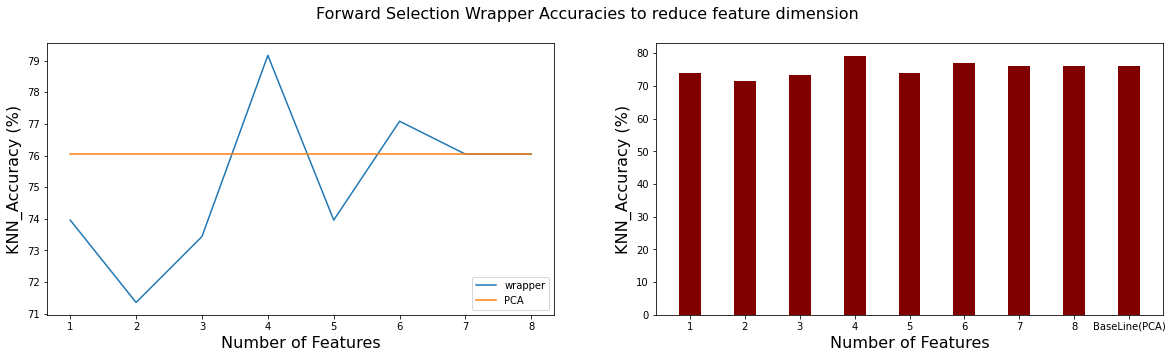

In [61]:
plot_curve_bar_chart_for_Wrapper(n_components,KNN_accs_forward,'KNN','Forward Selection',KNN_acc_summary[1])

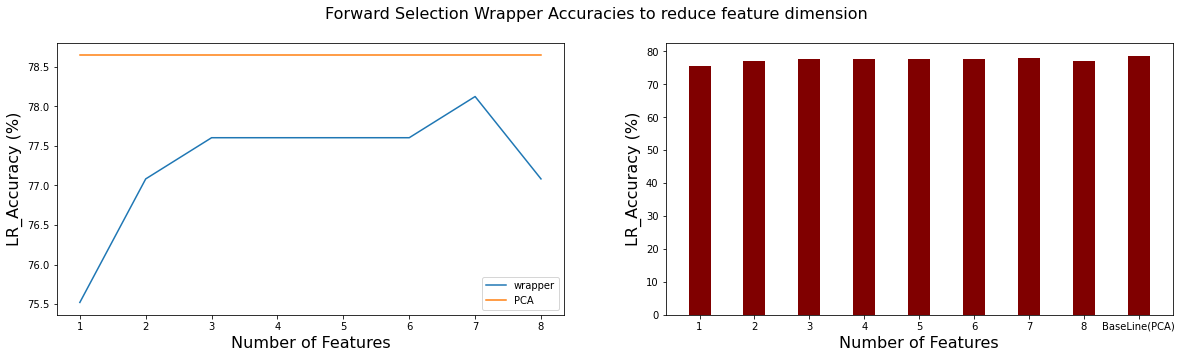

In [62]:
plot_curve_bar_chart_for_Wrapper(n_components,LR_accs_forward,'LR','Forward Selection',LR_acc_summary[1])

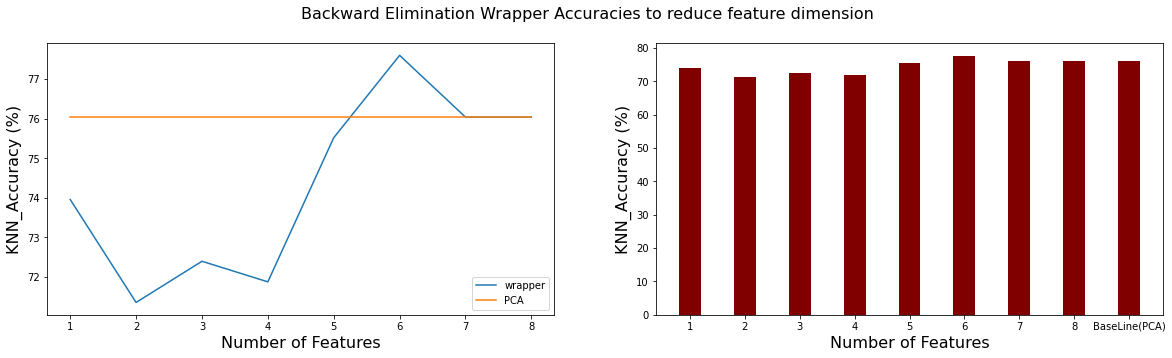

In [63]:
plot_curve_bar_chart_for_Wrapper(n_components,KNN_accs_backward,'KNN','Backward Elimination',KNN_acc_summary[1])

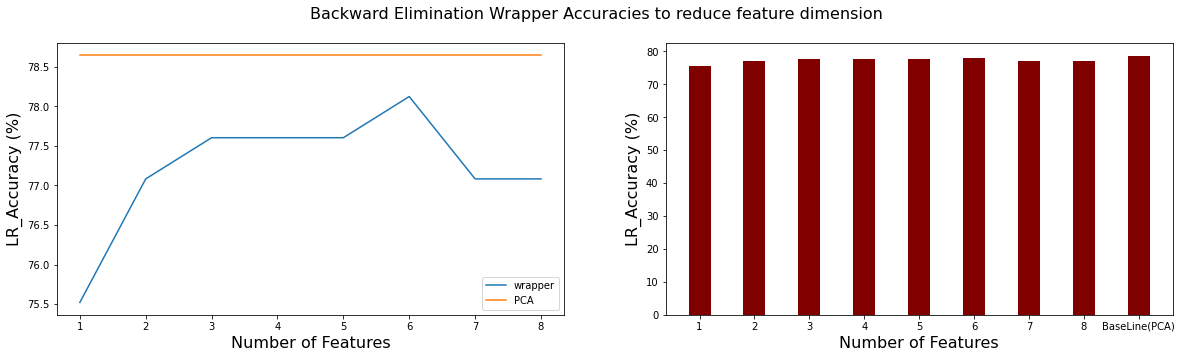

In [64]:
plot_curve_bar_chart_for_Wrapper(n_components,LR_accs_backward,'LR','Backward Elimination',LR_acc_summary[1])


(c) Provide 2D TSNE plots, one for the training set and one for the test set, using
only the best method (either the filter or wrapper). 

highest accuracy for: KNN after applying Forward Selection is 79.16666666666666
number of features 4 features : [Glucose, BloodPressure, BMI, Age]


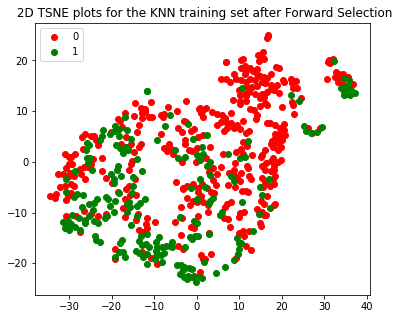

highest accuracy for: KNN after applying Forward Selection is 79.16666666666666
number of features 4 features : [Glucose, BloodPressure, BMI, Age]


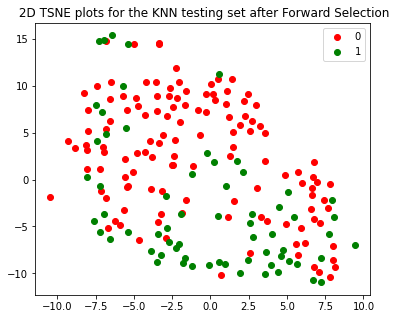

In [65]:
KNN_max_acc_forward=max(KNN_accs_forward)
KNN_max_acc_forward_index = KNN_accs_forward.index(KNN_max_acc_forward)
plot_tsne_wrapper(X_train[KNN_features_forward[KNN_max_acc_forward_index]], y_train, target_names," 2D TSNE plots for the KNN training set after Forward Selection",'KNN','Forward Selection',KNN_max_acc_forward,KNN_features_forward[KNN_max_acc_forward_index])
plot_tsne_wrapper(X_test[KNN_features_forward[KNN_max_acc_forward_index]], y_test, target_names," 2D TSNE plots for the KNN testing set after Forward Selection",'KNN','Forward Selection',KNN_max_acc_forward,KNN_features_forward[KNN_max_acc_forward_index])

highest accuracy for: LR after applying Forward Selection is 78.125
number of features 7 features : [Pregnancies, Glucose, BloodPressure, Insulin, BMI, DiabetesPedigreeFunction, Age]


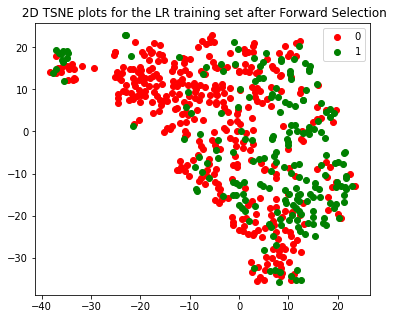

highest accuracy for: LR after applying Forward Selection is 78.125
number of features 7 features : [Pregnancies, Glucose, BloodPressure, Insulin, BMI, DiabetesPedigreeFunction, Age]


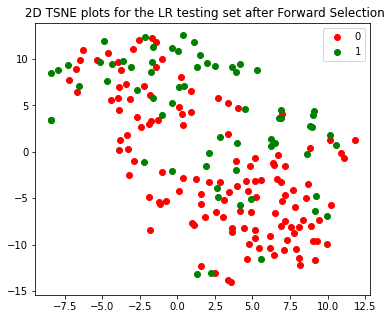

In [66]:
LR_max_acc_forward=max(LR_accs_forward)
LR_max_acc_forward_index = LR_accs_forward.index(LR_max_acc_forward)
plot_tsne_wrapper(X_train[LR_features_forward[LR_max_acc_forward_index]], y_train, target_names," 2D TSNE plots for the LR training set after Forward Selection",'LR','Forward Selection',LR_max_acc_forward,LR_features_forward[LR_max_acc_forward_index])
plot_tsne_wrapper(X_test[LR_features_forward[LR_max_acc_forward_index]], y_test, target_names," 2D TSNE plots for the LR testing set after Forward Selection",'LR','Forward Selection',LR_max_acc_forward,LR_features_forward[LR_max_acc_forward_index])

highest accuracy for: KNN after applying Backward Selection is 77.60416666666666
number of features 6 features : [Pregnancies, Glucose, BloodPressure, Insulin, BMI, Age]


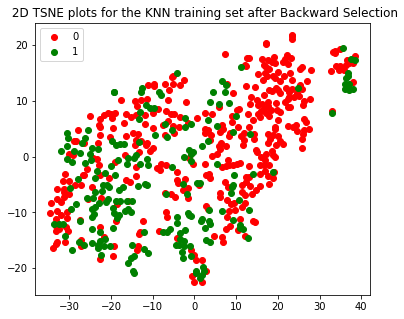

highest accuracy for: KNN after applying Backward Selection is 77.60416666666666
number of features 6 features : [Pregnancies, Glucose, BloodPressure, Insulin, BMI, Age]


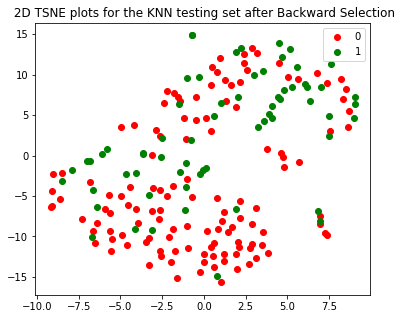

In [67]:
KNN_max_acc_backward=max(KNN_accs_backward)
KNN_max_acc_backward_index = KNN_accs_backward.index(KNN_max_acc_backward)
plot_tsne_wrapper(X_train[KNN_features_backward[KNN_max_acc_backward_index]], y_train, target_names," 2D TSNE plots for the KNN training set after Backward Selection",'KNN','Backward Selection',KNN_max_acc_backward,KNN_features_backward[KNN_max_acc_backward_index])
plot_tsne_wrapper(X_test[KNN_features_backward[KNN_max_acc_backward_index]], y_test, target_names," 2D TSNE plots for the KNN testing set after Backward Selection",'KNN','Backward Selection',KNN_max_acc_backward,KNN_features_backward[KNN_max_acc_backward_index])

highest accuracy for: LR after applying Backward Selection is 78.125
number of features 6 features : [Pregnancies, Glucose, BloodPressure, BMI, DiabetesPedigreeFunction, Age]


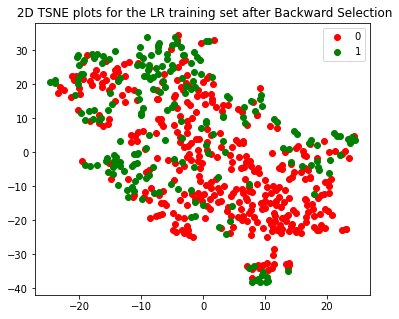

highest accuracy for: LR after applying Backward Selection is 78.125
number of features 6 features : [Pregnancies, Glucose, BloodPressure, BMI, DiabetesPedigreeFunction, Age]


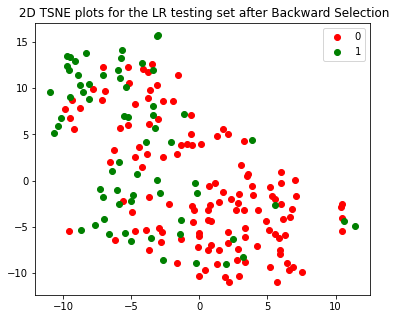

In [68]:
LR_max_acc_backward=max(LR_accs_backward)
LR_max_acc_backward_index = LR_accs_backward.index(LR_max_acc_backward)
plot_tsne_wrapper(X_train[LR_features_backward[LR_max_acc_backward_index]], y_train, target_names," 2D TSNE plots for the LR training set after Backward Selection",'LR','Backward Selection',LR_max_acc_backward,LR_features_backward[LR_max_acc_backward_index])
plot_tsne_wrapper(X_test[LR_features_backward[LR_max_acc_backward_index]], y_test, target_names," 2D TSNE plots for the LR testing set after Backward Selection",'LR','Backward Selection',LR_max_acc_backward,LR_features_backward[LR_max_acc_backward_index])

------------------------------------------------------------------------------------

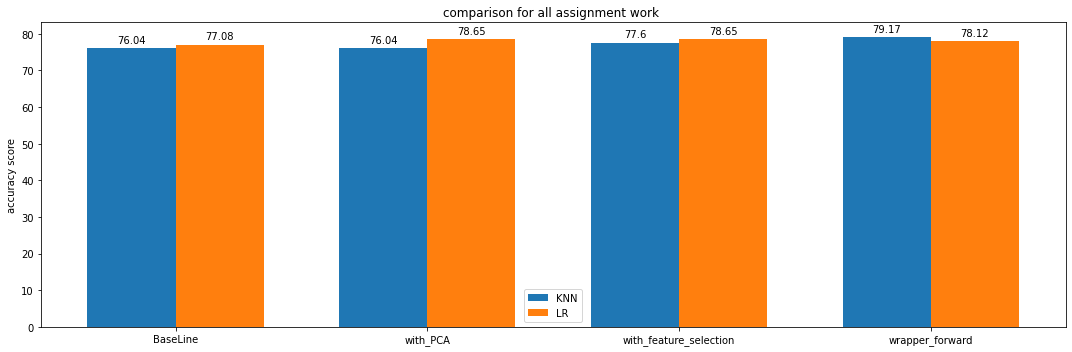

In [69]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = KNN_title_summary
KNN_acc = [round(x, 2) for x in KNN_acc_summary]
LR_acc = [ round(x, 2) for x in LR_acc_summary]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))

rects1 = ax.bar(x - width/2, KNN_acc, width, label='KNN')
rects2 = ax.bar(x + width/2, LR_acc, width, label='LR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('accuracy score')
ax.set_title('comparison for all assignment work ')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

## 5. Choose the best number of cluster for k-means clustering algorithm on the processed data, using the best features from Q3 or best number of dimensionality Q4.

In [70]:
def plot_kmeans_siloutte_score_problem5(X, max_clusters,method_name,model_name):
    """this function Plots the silhouette score vs the number of clusters"""
    wcss = []
    silut = []
    for i in range(2, max_clusters+1):
        # build the model with i clusters 
        k_m = build_kmeans(X, i)

        # we started with 2 clusters because selloute must have at least two clusters not only one cluster
        
        #silhouette_score : return Mean Silhouette Coefficient for all samples.
        silut.append(silhouette_score(X, k_m.labels_))

    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(f"silhouette score for K-means model based on the data from applying {method_name} with {model_name}")


    sub1 = plt.subplot(1, 2, 1)
    sub1.plot(range(2, max_clusters+1), silut)
    sub1.set_xlabel('Number of clusters')
    sub1.set_ylabel('silhouette score')
    
    plt.show()

(a) Plot the silhouette score vs the number of clusters

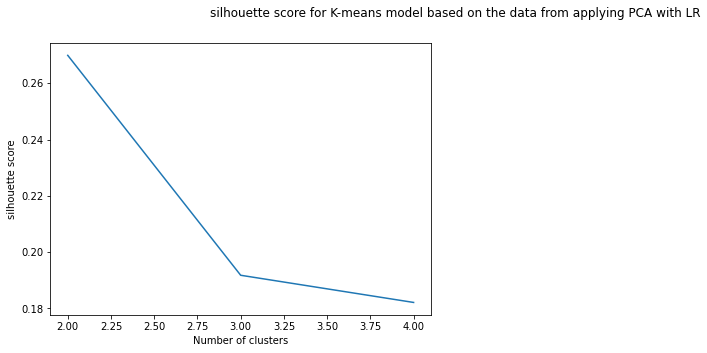

In [71]:
plot_kmeans_siloutte_score_problem5(LR_data_summary[1], 4,"PCA","LR")

(b) Determine the optimal number of clusters for k-means

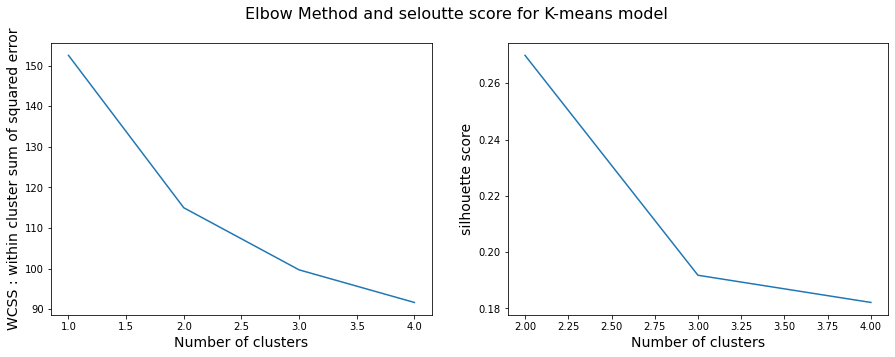

In [72]:
plot_kmeans_evaluation_measures(LR_data_summary[1], 4)

In [73]:
kmeans_model2 = KMeans(n_clusters=2, init='k-means++', random_state=0)

label2 = kmeans_model2.fit_predict(LR_data_summary[1])

## Visualize the principal components

In [74]:
import plotly.express as px

df = pd.DataFrame(LR_data_summary[1],columns=[ "PCA 1", "PCA 2", "PCA 3","PCA 4","PCA 5","PCA 6","PCA 7"])
df['target']=label
features = [ "PCA 1", "PCA 2", "PCA 3","PCA 4","PCA 5","PCA 6","PCA 7"]
fig = px.scatter_matrix(
    df,
    dimensions=features,
  color="target"
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [75]:
LR_data_summary[1][0]

array([ 0.15367054,  0.05355414,  0.06282723,  0.12743405, -0.17808659,
        0.08071567,  0.1422737 ])

In [76]:
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.411765,0.623116,0.573770,0.333333,0.254137,0.380030,0.035440,0.266667
1,0.294118,0.542714,0.590164,0.434343,0.088652,0.538003,0.078992,0.200000
2,0.058824,0.437186,0.491803,0.373737,0.088652,0.554396,0.184031,0.016667
3,0.058824,0.723618,0.672131,0.464646,0.212766,0.687034,0.109735,0.416667
4,0.058824,0.557789,0.508197,0.131313,0.215130,0.357675,0.025619,0.033333
...,...,...,...,...,...,...,...,...
763,0.000000,0.587940,0.655738,0.313131,0.062648,0.673621,0.004697,0.050000
764,0.705882,0.422111,0.590164,0.313131,0.000000,0.442623,0.093510,0.416667
765,0.352941,0.618090,0.590164,0.454545,0.271868,0.500745,0.279675,0.216667
766,0.058824,0.984925,0.622951,0.363636,0.294326,0.543964,0.340307,0.133333


---------------------------------------------------------------------------------------------------------

## 6. Choose the best number of neurons for SOM algorithm, using the best features from Q3 or best number of dimensionality Q4. You might find it easier if you use the MiniSom library.

(a) Plot the silhouette score vs the number of neurons (max 30 neurons) 

In [77]:
from minisom import MiniSom
def Silhouette_minSomfun(data,dm):

  s = []
  for i in range(2, 31):
      som_shape = (i, 1)
      som = MiniSom(som_shape[0], som_shape[1],dm, random_seed=0)
      som.train_batch(data, 1000, verbose=False)
      # each neuron represents a cluster
      winner_coordinates = np.array([som.winner(x) for x in data]).T
      # with np.ravel_multi_index we convert the bidimensional
      # coordinates to a monodimensional index
      labels = np.ravel_multi_index(winner_coordinates, som_shape)
      
      s.append(silhouette_score(data, labels))
      
  X_axis_values= []
  for j in range(2,31):
     X_axis_values.append(str(j))

  # plot number of neurons/number of clusters vs inertia score
  plt.figure(figsize=(15, 5))
  plt.plot(X_axis_values,s)
  plt.title('the silhouette score vs the number of neurons (max 30 neurons)')
  plt.xlabel("number of neurons")
  plt.ylabel("silloute score")
  plt.show()

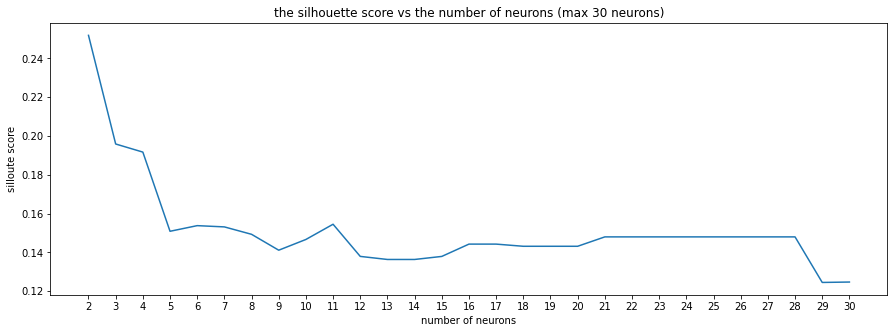

In [78]:
_,dim = pd.DataFrame(LR_data_summary[1]).shape
X_som = LR_data_summary[1]
Silhouette_minSomfun(X_som,dim)

(b) Determine the optimal number of neurons for SOM

based on the curve of (number_Of_neurons vs silloute_score)  the heighest point on the curve referes to the optimal number of neuron which is equal to 2 in this case 

(c) Plot the initial and final Neuron positions

In [79]:
def bestminSomMode(data,dm,n_clusters,n_iteration):
      som_shape = (n_clusters, 1)
      som = MiniSom(som_shape[0], som_shape[1],dm, random_seed=0)
      # initial Weight
      initial_positions = np.array(som.get_weights())
      som.train_batch(data, n_iteration, verbose=True)
      # Final Weight
      Final_positions = np.array(som.get_weights())
      # each neuron represents a cluster
      winner_coordinates = np.array([som.winner(x) for x in data]).T
      # with np.ravel_multi_index we convert the bidimensional
      # coordinates to a monodimensional index
      labels = np.ravel_multi_index(winner_coordinates, som_shape)

      return labels, initial_positions,Final_positions

In [80]:
#We can plot each cluster with a different color:
def PlotSom(title,data,cluster_index, init = None, final = None):
  _,dim = data.shape
  X_2d = data
  if dim > 2 :
    #reduce dim of data and initial_positions
    tsne = TSNE(n_components=2, random_state=0)
    if init is not None:
      X_2d = np.append(data, init, axis=0)
      X_2d = tsne.fit_transform(X_2d)
      init = X_2d[-2:]
      X_2d = X_2d[:-2]
    #reduce dim of data and Finial_positions
    if final is not None:
      X_2d = np.append(data, final, axis=0)
      X_2d = tsne.fit_transform(X_2d)
      final = X_2d[-2:]
      X_2d = X_2d[:-2]

  # plotting the clusters using the first 2 dimentions of the data
  for c in np.unique(cluster_index):
      plt.scatter(X_2d[cluster_index == c, 0],
                  X_2d[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)
      
  # plotting centroids
  if init is not None:
    # for centroid in init:
    plt.plot(init[:,0], init[:,1],marker='o',c='g', markeredgecolor = 'black', markersize=15, label="Neuron")
  if final is not None:
    # for centroid in final:
    plt.plot(final[:,0], final[:,1],marker='o',c='g', markeredgecolor = 'black', markersize=15, label="Neuron")
  plt.title(title)
  plt.legend()

In [81]:
labels, initial_positions, final_positions= bestminSomMode(X_som,dim,2,1000)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.39194412444362464


In [82]:
initial_positions = initial_positions.reshape((2, dim))
final_positions = final_positions.reshape((2, dim))

In [83]:
initial_positions

array([[ 0.16069505,  0.70840777,  0.33829913,  0.14775635, -0.25132995,
         0.48028639, -0.20546417],
       [ 0.48453665,  0.57344839, -0.14415709,  0.36079942,  0.03573663,
         0.08415609,  0.52636901]])

In [84]:
final_positions

array([[ 0.13212029, -0.14884912, -0.13478007,  0.06805394, -0.01087672,
         0.04231819, -0.1122581 ],
       [-0.15041313, -0.02514453,  0.0164025 , -0.0851228 ,  0.01513862,
        -0.06266636,  0.01079227]])

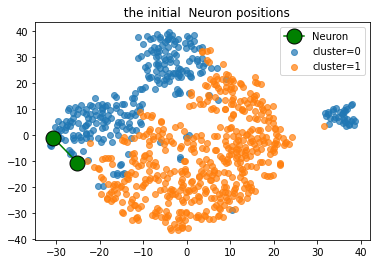

In [85]:
PlotSom("  the initial  Neuron positions",X_som,labels,initial_positions)

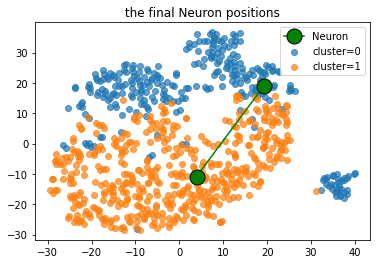

In [86]:
PlotSom(" the final Neuron positions ",X_som,labels,final_positions)

--------------------------------------------------------------------------------------------------------------------

### 7. Tune the epsilon (0.3-0.7) and minpoints (2-15) values to obtain the same number of clusters in Q6 by using DBSCAN. Provide two separate plots; where you show only the best 10 combinations of epsilon and minpoints that brings you closer to the desired cluster number with the highest silhouette score.

In [87]:
def plot_curve_bar_chart_for_DBScan(on_X,on_Y,ytitle,title):
    fig = plt.figure(figsize=(25, 5))
    fig.suptitle(title,fontsize=16)
    plt.subplot(1, 2, 1)
    x_labels = []
    
    for i,v in enumerate(on_X):
      s = " "*i 
      x_labels.append(str(round(v,2))+s) 
    # plt.xticks(x_labels)
    plt.plot(x_labels,on_Y)
    plt.scatter(x_labels,on_Y, c='red', s=80)
    plt.xlabel(ytitle, fontsize=16)
    plt.ylabel(" number of clusters ", fontsize=16)


    
    
    
    plt.show()

In [88]:
from math import nan

parameters = {'eps':[0.3,0.4,0.5,0.6,0.7], 'min_samples':[2, 15]}
DBscan = DBSCAN()
#find DBSCAN optimal eps and min-samples 
epsList, msList, accList,scores,clusters = list(), list(), list(),list(),list()
score=0
minOneFlag=False
for eps in tqdm(np.arange(0.3, 0.7,0.01)):
  for ms in range(2, 16):
    model = DBSCAN(eps=eps, min_samples=ms)
    predLabels = model.fit_predict(X)
    minOneFlag=False
    Ks=list(set(predLabels))
    if -1 in Ks:
      minOneFlag = True
      Ks.remove(-1)
    if len(Ks)==1 and minOneFlag==False:
      score = nan
    else: 
      score = silhouette_score(X, predLabels, random_state=42)
    scores.append(score)
    epsList.append(eps)
    msList.append(ms)
    accList.append(score)
    clusters.append(Ks)
     
epsList, msList, accList,scoresList ,clustersList= np.array(epsList), np.array(msList), np.array(accList),np.array(scores),np.array(clusters)


100%|██████████| 40/40 [00:18<00:00,  2.11it/s]


In [89]:
table = pd.DataFrame(epsList,columns=['Epsilon'])
table['MinPoints']= msList
table['Silhouette']=scoresList 
table['Clusters']=clustersList
data=[] 
indexes = []
for index,val in enumerate(table.values):
  if len(val[-1])==2:
    data.append(val)
    indexes.append(index)
tables = pd.DataFrame(data,columns=['Epsilon','MinPoints','Silhouette','Clusters'],index=indexes)   
tables= tables.nlargest(n=10,columns=['Silhouette'])

In [90]:
tables['Clusters']=len(tables.iloc[0,-1])

In [91]:
tables 

,Epsilon,MinPoints,Silhouette,Clusters
210,0.45,2,0.427027,2
182,0.43,2,0.416000,2
168,0.42,2,0.413268,2
196,0.44,2,0.400058,2
60,0.34,6,0.310229,2
43,0.33,3,0.302940,2
44,0.33,4,0.302940,2
45,0.33,5,0.301469,2
46,0.33,6,0.301469,2
30,0.32,4,0.294262,2


(a) First plot is epsilon vs number of clusters. 

In [92]:
clstrs_nums = []
for i in tables['Clusters']:
  clstrs_nums.append(str(i))


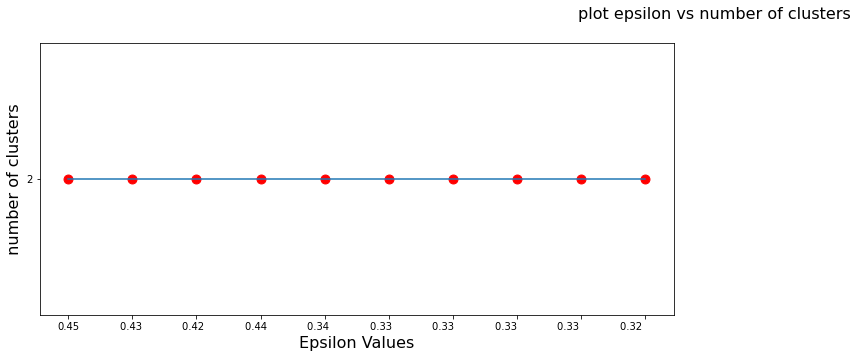

In [93]:
plot_curve_bar_chart_for_DBScan(tables['Epsilon'],clstrs_nums,'Epsilon Values','plot epsilon vs number of clusters')

(b) Second plot is minpoints vs number of clusters.

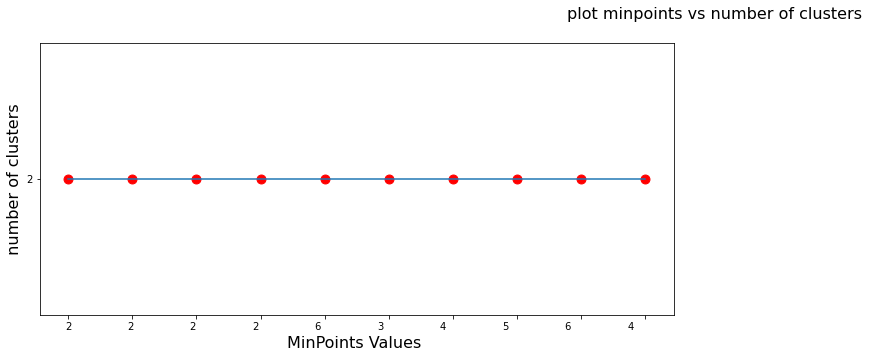

In [94]:
plot_curve_bar_chart_for_DBScan(tables['MinPoints'],clstrs_nums,'MinPoints Values ','plot minpoints vs number of clusters')

--------------------------------------------------------------------------------------------------------------------